# [ QHM5703 MiniProject 2425 ]

# 1 Author

**Student Name**:  Feifan Liu
**Student ID**:  221155682



# 2 Problem formulation

Describe the machine learning problem that you want to solve and explain what's interesting about it.

# 3 Methodology

Describe your methodology. Specifically, describe your training task and validation task, and how model performance is defined (i.e. accuracy, confusion matrix, etc). Any other tasks that might help you build your model should also be described here.

# 4 Implemented ML prediction pipelines

Describe the ML prediction pipelines that you will explore. Clearly identify their input and output, stages and format of the intermediate data structures moving from one stage to the next. It's up to you to decide which stages to include in your pipeline. After providing an overview, describe in more detail each one of the stages that you have included in their corresponding subsections (i.e. 4.1 Transformation stage, 4.2 Model stage, 4.3 Ensemble stage).

## 4.1 Transformation stage

Describe any transformations, such as feature extraction. Identify input and output. Explain why you have chosen this transformation stage.

## 4.2 Model stage



## 4.3 Ensemble stage



# 5 Dataset



In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys, re, pickle, glob
import IPython.display as ipd
import librosa
import spkit as sp

In [ ]:
######## Split audio files into 30s segments ########

from pydub import AudioSegment
import glob
import os


sample_path = './MLEndDD_stories_small/*.wav'
files = glob.glob(sample_path)


output_dir = './output_30s/'
os.makedirs(output_dir, exist_ok=True)

# Split audio files into 30s segments
for file in files:
    audio = AudioSegment.from_wav(file)
    duration = len(audio)
    segment_duration = 30000  # 30s
    num_segments = duration // segment_duration

    for i in range(num_segments):
        start_time = i * segment_duration
        end_time = start_time + segment_duration
        audio_segment = audio[start_time:end_time]
        output_file = os.path.join(output_dir, f"{os.path.basename(file).split('.')[0]}_segment_{i+1}.wav")
        with open(output_file, 'wb') as f:
            audio_segment.export(f, format="wav")


In [13]:
######## Create CSV file with story attributes for 30s segments ########

import pandas as pd
import os

MLEND_df = pd.read_csv('./MLEndDD_story_attributes_small.csv')

new_rows = []

segment_path = './output_30s/*.wav'
segment_files = glob.glob(segment_path)

for segment_file in segment_files:
    segment_filename = os.path.basename(segment_file)
    original_filename = segment_filename.split('_segment_')[0] + '.wav'
    
    original_row = MLEND_df[MLEND_df['filename'] == original_filename].iloc[0]
    
    new_rows.append({
        'filename': segment_filename,
        'Language': original_row['Language'],
        'Story_type': original_row['Story_type']
    })

new_MLEND_df = pd.DataFrame(new_rows)

new_MLEND_df.to_csv('./MLEndDD_story_attributes_30s.csv', index=False)

print(f"Saved {len(new_MLEND_df)} rows to MLEndDD_story_attributes_30s.csv")


######## Store the path of the 30s segments in a pickle file ########
files = 'output_30s/' + new_MLEND_df['filename']

Saved 420 rows to MLEndDD_story_attributes_30s.csv


## 5.1 Dataset A

In [14]:
import os
import librosa
import numpy as np

def extract_features(audio_path, n_mfcc=13, frame_length=0.03, frame_stride=0.03, sr=16000):
    # Load audio
    audio, sr = librosa.load(audio_path, sr=sr)
    
    # Compute MFCC features
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, 
                                hop_length=int(frame_stride*sr), 
                                n_fft=int(frame_length*sr))
    
    # Compute pitch (音高) features
    pitches, magnitudes = librosa.core.piptrack(y=audio, sr=sr, 
                                                hop_length=int(frame_stride*sr), 
                                                n_fft=int(frame_length*sr))
    
    # Select the highest pitch for each frame
    pitch = []
    for t in range(pitches.shape[1]):
        index = magnitudes[:, t].argmax()
        pitch.append(pitches[index, t])
    pitch = np.array(pitch)
    
    # Combine MFCC and pitch features
    features = np.concatenate((mfcc, pitch[np.newaxis, :]), axis=0)
    
    # Compute the mean of each feature
    features_mean = np.mean(features, axis=1)
    
    return features_mean

def process_audio_files(dataframe, audio_dir, n_mfcc=13, language=None, first_segment_only=False):
    """
    处理指定语言的音频文件，并根据 dataframe 中的标签提取特征。
    Args:
        dataframe: 包含文件名、语言和故事类型的 DataFrame。
        audio_dir: 存放音频文件的目录。
        n_mfcc: 每帧提取的 MFCC 特征数量。
        language: 需要筛选的语言（如 'English'），如果为 None，则处理所有语言。
        first_segment_only: 是否只处理每个音频文件的第一个片段。
    Returns:
        features: 提取的 MFCC 特征数组。
        labels: 对应的标签数组。
    """
    features = []
    labels = []
    
    # 筛选指定语言的数据
    if language:
        dataframe = dataframe[dataframe['Language'] == language]
    
    for index, row in dataframe.iterrows():
        filename = row['filename']
        label = row['Story_type']  # 假设 Story_type 是你的标签列
        file_path = os.path.join(audio_dir, filename)
        
        if first_segment_only and not filename.endswith('_segment_1.wav'):
            continue
        
        if os.path.exists(file_path):
            try:
                mfcc_features = extract_features(file_path, n_mfcc=n_mfcc)
                features.append(mfcc_features)
                labels.append(label)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")
        else:
            print(f"File not found: {file_path}")
    
    return np.array(features), np.array(labels)

In [15]:
# Extract MFCC features for each 30s segment

## Only Choose the first segment of each story
X_a, y_a = process_audio_files(new_MLEND_df, audio_dir='output_30s/', n_mfcc=40, language='English', first_segment_only=True)


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import train_test_split

label_encoder = LabelEncoder()

# transform the labels to integers
y_a = label_encoder.fit_transform(y_a)

print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


# Normalize the features
mean = X_a.mean(0)
sd = X_a.std(0)

X_a = (X_a - mean) / sd

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_a, y_a, test_size=0.3)

print(f'Training set shape: {X_train.shape}, {y_train.shape}')
print(f'Validation set shape: {X_val.shape}, {y_val.shape}')



## Group audio segments by original story and split into training and validation sets
""" # Use the original filename as the group
new_MLEND_df['file_prefix'] = new_MLEND_df['filename'].apply(lambda x: x.split('_segment_')[0])

# Split the data into training and validation sets
gss = GroupShuffleSplit(n_splits=1, test_size=0.3)
train_idx, val_idx = next(gss.split(new_MLEND_df, groups=new_MLEND_df['file_prefix']))

train_df = new_MLEND_df.iloc[train_idx]
val_df = new_MLEND_df.iloc[val_idx]

# Extract MFCC features for each 30s segment
X_train, y_train = process_audio_files(train_df, audio_dir='output_30s/', n_mfcc=40, language='English', first_segment_only=False)
X_val, y_val = process_audio_files(val_df, audio_dir='output_30s/', n_mfcc=40, language='English', first_segment_only=False)

# Transform the labels to integers
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)

print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# Normalize the features
mean = X_train.mean(0)
sd = X_train.std(0)

X_train = (X_train - mean) / sd
X_val = (X_val - mean) / sd

print(f'Training set shape: {X_train.shape}, {y_train.shape}')
print(f'Validation set shape: {X_val.shape}, {y_val.shape}') """

{np.str_('deceptive_story'): np.int64(0), np.str_('true_story'): np.int64(1)}
Training set shape: (54, 41), (54,)
Validation set shape: (24, 41), (24,)


" # Use the original filename as the group\nnew_MLEND_df['file_prefix'] = new_MLEND_df['filename'].apply(lambda x: x.split('_segment_')[0])\n\n# Split the data into training and validation sets\ngss = GroupShuffleSplit(n_splits=1, test_size=0.3)\ntrain_idx, val_idx = next(gss.split(new_MLEND_df, groups=new_MLEND_df['file_prefix']))\n\ntrain_df = new_MLEND_df.iloc[train_idx]\nval_df = new_MLEND_df.iloc[val_idx]\n\n# Extract MFCC features for each 30s segment\nX_train, y_train = process_audio_files(train_df, audio_dir='output_30s/', n_mfcc=40, language='English', first_segment_only=False)\nX_val, y_val = process_audio_files(val_df, audio_dir='output_30s/', n_mfcc=40, language='English', first_segment_only=False)\n\n# Transform the labels to integers\nlabel_encoder = LabelEncoder()\ny_train = label_encoder.fit_transform(y_train)\ny_val = label_encoder.transform(y_val)\n\nprint(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))\n\n# Normalize the features\n

## 5.2 Dataset B

In [ ]:
def extract_features_sequence(audio_path, n_mfcc=13, frame_length=0.186, frame_stride=0.186, sr=16000):
    # Load audio
    audio, sr = librosa.load(audio_path, sr=sr)
    
    # Compute MFCC features
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, 
                                hop_length=int(frame_stride*sr), 
                                n_fft=int(frame_length*sr))
    
    # Compute pitch features
    pitches, magnitudes = librosa.core.piptrack(y=audio, sr=sr, 
                                                hop_length=int(frame_stride*sr), 
                                                n_fft=int(frame_length*sr))
    
    # Select the highest pitch for each frame
    pitch = []
    for t in range(pitches.shape[1]):
        index = magnitudes[:, t].argmax()
        pitch.append(pitches[index, t])
    pitch = np.array(pitch)
    
    # Combine MFCC and pitch features
    features = np.concatenate((mfcc.T, pitch[:, np.newaxis]), axis=1)
    
    return features

def process_audio_files_sequence(dataframe, audio_dir, n_mfcc=13, language=None, first_segment_only=False):
    features = []
    labels = []
    
    # Filters data for the specified language
    if language:
        dataframe = dataframe[dataframe['Language'] == language]
    
    for index, row in dataframe.iterrows():
        filename = row['filename']
        label = row['Story_type']
        file_path = os.path.join(audio_dir, filename)
        
        if first_segment_only and not filename.endswith('_segment_1.wav'):
            continue
        
        if os.path.exists(file_path):
            try:
                feature = extract_features_sequence(file_path, n_mfcc=n_mfcc)
                features.append(feature)
                labels.append(label)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")
        else:
            print(f"File not found: {file_path}")
    
    return np.array(features), np.array(labels)

In [ ]:
## Only Choose the first segment of each story
X_b, y_b = process_audio_files_sequence(new_MLEND_df, audio_dir='output_30s/', n_mfcc=40, language='English', first_segment_only=True)

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# transform the labels to integers
y_b = label_encoder.fit_transform(y_b)


# Normalize the features
mean = X_b.mean(0)
sd = X_b.std(0)

X_b = (X_b - mean) / sd



## Group audio segments by original story and split into training and validation sets
# Partition the dataset by file prefix grouping
""" gss = GroupShuffleSplit(n_splits=1, test_size=0.3)
train_idx_b, val_idx_b = next(gss.split(new_MLEND_df, groups=new_MLEND_df['file_prefix']))

train_df_b = new_MLEND_df.iloc[train_idx_b]
val_df_b = new_MLEND_df.iloc[val_idx_b]

X_train_b, y_train_b = process_audio_files_sequence(train_df_b, audio_dir='output_30s/', n_mfcc=40, language='English', first_segment_only=False)
X_val_b, y_val_b = process_audio_files_sequence(val_df_b, audio_dir='output_30s/', n_mfcc=40, language='English', first_segment_only=False)

label_encoder_b = LabelEncoder()
y_train_b = label_encoder_b.fit_transform(y_train_b)
y_val_b = label_encoder_b.transform(y_val_b)

print(dict(zip(label_encoder_b.classes_, label_encoder_b.transform(label_encoder_b.classes_))))

# Normalize the features
mean_b = X_train_b.mean(0)
sd_b = X_train_b.std(0)

X_train_b = (X_train_b - mean_b) / sd_b
X_val_b = (X_val_b - mean_b) / sd_b

print(f'Training set shape: {X_train_b.shape}, {y_train_b.shape}')
print(f'Validation set shape: {X_val_b.shape}, {y_val_b.shape}') """

# 6 Experiments and results



## Dataset A

In [ ]:
from sklearn import svm
import numpy as np
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import numpy as np

# define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

model = svm.SVC()

# define the grid search
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_a, y_a)


print('Best Parameters:', grid_search.best_params_)
print('Best Cross-Validation Accuracy:', grid_search.best_score_)

Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best Cross-Validation Accuracy: 0.5416666666666666


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
import numpy as np

# define the parameter grid for each model
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

param_grid_dt = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'criterion': ['gini', 'entropy']
}

param_grid_rf = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

param_grid_nb = {}

# define the models
modelLR = LogisticRegression()
modelDT = DecisionTreeClassifier()
modelRF = RandomForestClassifier()
modelKNN = KNeighborsClassifier()
modelNB = GaussianNB()

# define the grid search for each model
grid_search_lr = GridSearchCV(modelLR, param_grid_lr, cv=5, scoring='accuracy')
grid_search_dt = GridSearchCV(modelDT, param_grid_dt, cv=5, scoring='accuracy')
grid_search_rf = GridSearchCV(modelRF, param_grid_rf, cv=5, scoring='accuracy')
grid_search_knn = GridSearchCV(modelKNN, param_grid_knn, cv=5, scoring='accuracy')
grid_search_nb = GridSearchCV(modelNB, param_grid_nb, cv=5, scoring='accuracy')

# fit the grid search
grid_search_lr.fit(X_a, y_a)
grid_search_dt.fit(X_a, y_a)
grid_search_rf.fit(X_a, y_a)
grid_search_knn.fit(X_a, y_a)
grid_search_nb.fit(X_a, y_a)


print('Best Parameters of Logistic Regression:', grid_search_lr.best_params_)
print('Best Cross-Validation Accuracy of Logistic Regression:', grid_search_lr.best_score_)

print('Best Parameters of Decision Tree:', grid_search_dt.best_params_)
print('Best Cross-Validation Accuracy of Decision Tree:', grid_search_dt.best_score_)

print('Best Parameters of Random Forest:', grid_search_rf.best_params_)
print('Best Cross-Validation Accuracy of Random Forest:', grid_search_rf.best_score_)

print('Best Parameters of KNN:', grid_search_knn.best_params_)
print('Best Cross-Validation Accuracy of KNN:', grid_search_knn.best_score_)

print('Best Parameters of Naive Bayes:', grid_search_nb.best_params_)
print('Best Cross-Validation Accuracy of Naive Bayes:', grid_search_nb.best_score_)


d:\资料\QM\ML with Py\QHM5703_MiniProject\.venv\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
d:\资料\QM\ML with Py\QHM5703_MiniProject\.venv\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
d:\资料\QM\ML with Py\QHM5703_MiniProject\.venv\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
d:\资料\QM\ML with Py\QHM5703_MiniProject\.venv\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
d:\资料\QM\ML with Py\QHM5703_MiniProject\.venv\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
d:\资料\QM\ML with Py\QHM5703_MiniProject\.venv\lib\site-packages\sklearn\linear_model\_sag.

Best Parameters of Logistic Regression: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Best Cross-Validation Accuracy of Logistic Regression: 0.5541666666666667
Best Parameters of Decision Tree: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 5}
Best Cross-Validation Accuracy of Decision Tree: 0.5658333333333333
Best Parameters of Random Forest: {'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 10}
Best Cross-Validation Accuracy of Random Forest: 0.6033333333333333
Best Parameters of KNN: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'uniform'}
Best Cross-Validation Accuracy of KNN: 0.5391666666666667
Best Parameters of Naive Bayes: {}
Best Cross-Validation Accuracy of Naive Bayes: 0.4766666666666667


Test Accuracy: 0.6250


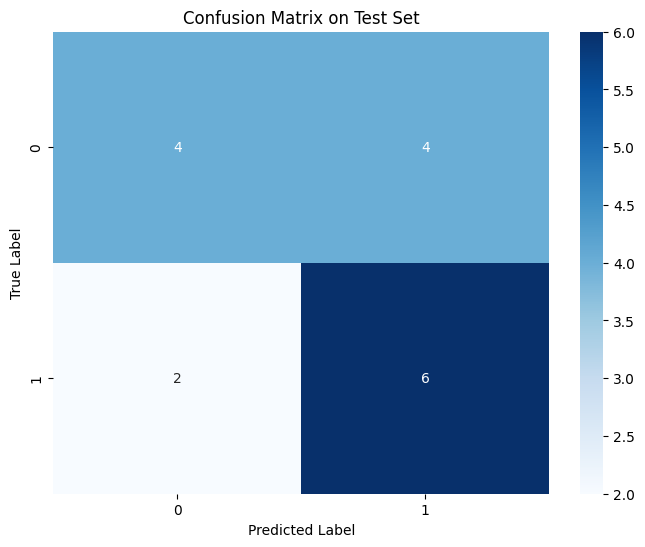

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(
    X_a, y_a, 
    test_size=0.2,
    stratify=y_a,
    random_state=10
)

best_rf = RandomForestClassifier(
    max_depth=30,
    min_samples_leaf=4,
    min_samples_split=10,
    n_estimators=10,
    bootstrap=False,
    random_state=42
)


best_rf.fit(X_train, y_train)


y_pred = best_rf.predict(X_test)


test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix on Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## Dataset B
Due to the lack of relevant research, the attempt for Dataset B is only reproduced as part of the proposed architecture of (Thaler et al., 2021).

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from sklearn.model_selection import KFold

def create_model(input_shape):
    inputs = Input(shape=input_shape)
    
    x = Conv1D(32, 3, activation='relu', kernel_regularizer=l2(0.001))(inputs)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.3)(x)
    
    x = Conv1D(64, 3, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.3)(x)

    x = LSTM(64, return_sequences=True)(x)
    x = LSTM(32)(x)
    
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.4)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def lr_schedule(epoch):
    initial_lr = 0.001
    if epoch < 5:  
        return float(initial_lr * ((epoch + 1) / 5))
    elif epoch < 30:
        return float(initial_lr)
    else:
        return float(initial_lr * tf.math.exp(0.1 * (30 - epoch)))



kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store the cross-validation scores
scores = []

for train_index, val_index in kf.split(X_b):
    X_train, X_val = X_b[train_index], X_b[val_index]
    y_train, y_val = y_b[train_index], y_b[val_index]
    
    model = create_model(input_shape=(X_train.shape[1], X_train.shape[2]))
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        LearningRateScheduler(lr_schedule),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=10,
            min_lr=0.00001
        )
    ]

    model.fit(
        X_train, 
        y_train,
        epochs=200,
        batch_size=32,
        validation_split=0.2,
        callbacks=callbacks,
        verbose=1
    )
    
    loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
    scores.append(accuracy)

# Cross-validation scores
print('Cross-Validation Scores:', scores)
print('Mean Cross-Validation Accuracy:', np.mean(scores))

Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 372ms/step - accuracy: 0.4148 - loss: 0.7776 - val_accuracy: 0.7692 - val_loss: 0.7489 - learning_rate: 2.0000e-04
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.4828 - loss: 0.7738 - val_accuracy: 0.6154 - val_loss: 0.7630 - learning_rate: 4.0000e-04
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5925 - loss: 0.7551 - val_accuracy: 0.6154 - val_loss: 0.7698 - learning_rate: 6.0000e-04
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.4964 - loss: 0.7655 - val_accuracy: 0.6154 - val_loss: 0.7662 - learning_rate: 8.0000e-04
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5789 - loss: 0.7582 - val_accuracy: 0.6154 - val_loss: 0.7620 - learning_rate: 0.0010
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5444 - loss: 0.7738 - val_accuracy: 0.7692 - val_loss: 0.7394 - learning_rate: 0.0010
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6918 - loss: 0.7232

# 7 Conclusions


# 8 References
[1] F. Thaler, S. Faußer, and H. Gewald, "Using NLP to analyze whether customer statements comply with their inner belief," arXiv preprint arXiv:2107.11175v2, 2021. [Online]. Available: https://doi.org/10.48550/arXiv.2107.11175.

[2] N. M. Müller, P. Czempin, F. Dieckmann, A. Froghyar, and K. Böttinger, "Does audio deepfake detection generalize?" *arXiv preprint arXiv:2203.16263v4*, 2024. [Online]. Available: https://doi.org/10.48550/arXiv.2203.16263.

[3] H. Rohde and A. Finkelstein, "An acoustic automated lie detector,", 2019. [Online]. Available: https://api.semanticscholar.org/CorpusID:204877090.

[4] McFee, B., Raffel, C., Liang, D., Ellis, D., McVicar, M., Battenberg, E., & Nieto, O. (2015). librosa: Audio and Music Signal Analysis in Python. In Proceedings of the 14th Python in Science Conference (pp. 18-24).

[5] Abadi, M., Agarwal, A., Barham, P., Brevdo, E., Chen, Z., Citro, C., ... & Zheng, X. (2016). TensorFlow: Large-scale machine learning on heterogeneous distributed systems. arXiv preprint arXiv:1603.04467.

[6] Zhang, J. (2021). Signal Processing Tool Kit (SPKIT). GitHub repository. https://github.com/Nikeshbajaj/spkit

[7] Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., ... & Duchesnay, E. (2011). Scikit-learn: Machine Learning in Python. Journal of Machine Learning Research, 12, 2825-2830.